PCR是一个两步过程：

* 对我们的数据运行PCA，以将自变量分解为“主要成分”，对应于删除相关成分
* 选择主成分的一个子集，然后对校准值进行回归

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

定义一个函数，该函数对输入数据执行简单的线性回归，
并运行交叉验证过程以估计确定系数（在Python中称为“得分”）和MSE

In [6]:
def simple_regression(X,y):
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Fit
    regr.fit(X, y)
    # Calibration校准
    y_c = regr.predict(X)
    # Cross-validation交叉验证
    y_cv = cross_val_predict(regr, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    #计算分数以进行校准和交叉验证
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean square error for calibration and cross validation
    #计算均方误差以进行校准和交叉验证
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    return(y_cv, score_c, score_cv, mse_c, mse_cv)

定义一个PCR函数，该函数首先对输入数据进行PCA分解，然后进行线性回归。

PCR函数需要一个额外的参数，pc。这是要选择的最大主成分数。PCA操作会产生与光谱或波长一样多的分量（取决于最大的那个），但是不需要全部用于回归。必须仅选择一些组件才能获得良好的模型，因为最高阶的组件往往会产生噪声，并降低模型的质量。

由于不知道用于解决问题的pc的最佳值，因此将循环运行此功能并最小化MSE

In [7]:
def pcr(X,y,pc):#pc:要选择的最大主成分数
    ''' Step 1: PCA on input data'''
    # Define the PCA object
    pca = PCA()
    # Preprocess (2) Standardize features by removing the mean and scaling to unit variance
    #预处理（2）通过去除均值并缩放到单位方差来标准化特征
    Xstd = StandardScaler().fit_transform(X)
    # Run PCA producing the reduced variable Xred and select the first pc components
    #运行PCA产生减少的变量Xred并选择第一个pc组件
    Xreg = pca.fit_transform(Xstd)[:,:pc]
    ''' Step 2: regression on selected principal components'''
    '''步骤2：对选定的主要成分进行回归'''
    y_cv, score_c, score_cv, mse_c, mse_cv = simple_regression(Xreg, y)
    return(y_cv, score_c, score_cv, mse_c, mse_cv)

In [9]:
# Read data
data = pd.read_csv(r'E:\Documents\DAY\DA_python\data\nirpyresearch-master\data\peach_spectra_brixvalues.csv')
X = data.values[:,1:]
y = data['Brix']

npc = 40 # maximum number of principal components
pc = range(1,npc+1,1)

# Define arrays for R^2 and MSE
r2c = np.zeros(npc)
r2cv = np.zeros(npc)
msec = np.zeros(npc)
msecv = np.zeros(npc)
for i in pc:
    predicted, r2c[i-1], r2cv[i-1], msec[i-1], msecv[i-1] = pcr(X,y, pc=i)

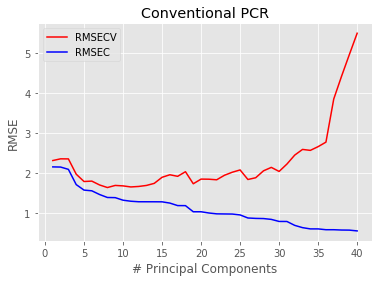

In [10]:
'''绘制用于校准和交叉验证（CV）的MSE阵列。
追求的是RMSE-CV的最小值，即均方根误差（即MSE的平方根）'''
with plt.style.context(('ggplot')):
    plt.plot(pc, np.sqrt(msecv[:]), 'r', label = "RMSECV")
    plt.plot(pc, np.sqrt(msec[:]), 'b', label = "RMSEC")
    plt.xlabel("# Principal Components")
    plt.ylabel("RMSE")
    plt.title("Conventional PCR")
    plt.legend()
    plt.show()

对于发生最小RMSE的pc 使用该pc值运行pcr函数，并绘制回归结果

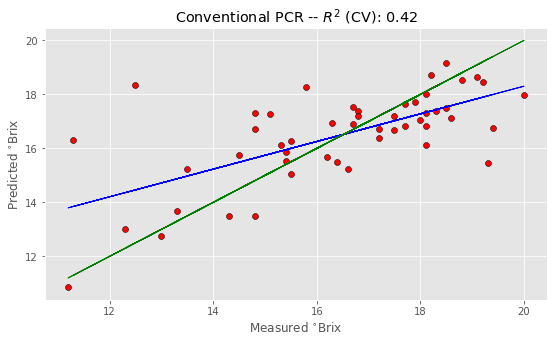

In [11]:
predicted, r2r, r2cv, mser, mscv = pcr(X,y, pc=8)
# Regression plot
z = np.polyfit(y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y, predicted, c='red', edgecolors='k')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1)
    plt.title('Conventional PCR -- $R^2$ (CV): {0:.2f}'.format(r2cv))
    plt.xlabel('Measured $^{\circ}$Brix')
    plt.ylabel('Predicted $^{\circ}$Brix')
    plt.show()

In [4]:
def pcr_revisited(X,y, pc):
    ''' Step 1: PCA on input data'''
    # Define the PCA object
    pca = PCA()
    # Preprocess (2) Standardize features by removing the mean and scaling to unit variance
    Xstd = StandardScaler().fit_transform(X)
    # Run PCA producing the reduced variable Xreg and select the first pc components
    Xpca = pca.fit_transform(Xstd)
    # Define a correlation array
    # 定义一个相关数组
    corr = np.zeros(Xpca.shape[1])
    # Calculate the absolute value of the correlation coefficients for each PC
    # 计算每个PC的相关系数的绝对值
    for i in range(Xpca.shape[1]):
        corr[i] = np.abs(np.corrcoef(Xpca[:,i], y)[0, 1])
    # Sort the array based on the corr values and select the last pc values 
    # 根据corr值对数组进行排序，然后选择最后一个pc值
    Xreg = (Xpca[:,np.argsort(corr)])[:,-pc:]
    ''' Step 2: regression on selected principal components'''
    y_cv, score_c, score_cv, mse_c, mse_cv = simple_regression(Xreg, y)
    return(y_cv, score_c, score_cv, mse_c, mse_cv)

* 用校准值计算每个PC阵列的相关系数
* 采用绝对值，要拒绝的是相关值接近零的PC。
* 按照相关性增加的顺序对PC阵列进行排序。
* 选择数组的最后一个pc值，它是相关性最大的值